In [1]:
from gorgo import infer, condition, draw_from, flip, keep_deterministic
from gorgo.hashable import hashabledict

from collections import namedtuple
import math
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# define named tuples
Utterance = namedtuple("Utterance", ("subj", "feature"))
Instance = namedtuple("Instance", ("kind", "features"))
Kind = namedtuple("Kind", ("name", "features"))

# equivalent to:
# class Utterance:
#     def __init__(self, subj, feature):
#         self.subj = subj`
#         self.feature = feature`


# helper functions
## convert gorgo dist to df for plotting
@keep_deterministic
def dist_to_df(dist):
    df_dist = pd.DataFrame(dist.support)
    df_dist['Probability'] = dist.probabilities
    return df_dist

## get all observed features from a dataset
@keep_deterministic
def get_observed_features(data: tuple[tuple[Utterance, Instance]]):
    every_observed_feature = []
    for pair in data:
        inst = pair[1]
        for feature in list(inst.features):             # list in case of tuple element 1
            every_observed_feature.append(feature)
    observed_features = set(every_observed_feature)     # remove duplicate features
    return observed_features


# Modeling inferences about category coherence from generics

* **listener**: considering only the *features observed*
* **speaker**: trying to communicate which *of the features observed* is kind-linked

## Literal listener

**Meaning function**

* Features are either kind-linked or not kind-linked. 
* A *generic statement* is true if the mentioned feature $f$ is in the set of features true of the category (i.e., the property is kind-linked).
* A *specific statement* is true if the mentioned feature $f$ is in the set of features true of the individual. 
* eq. 1:

$$[[u_i]](\mathcal{F}_k, x_i) = 
\begin{cases}
1[f \in \mathcal{F}_k] \text{, if } u_i = \text{"$k$s are $f$"}\\
1[f \in x_i] \text{, if } u_i = \text{"This $k$ is $f$"}\\
0 \text{, otherwise}
\end{cases}$$

In [3]:
# meaning function
def meaning(kind: Kind, inst: Instance, utt: Utterance):
    if "This" in utt.subj: # specific
        return utt.feature in inst.features  # specific is true = mentioned feature is in list of example instance's features
    else: # generic
        return utt.feature in kind.features   # generic is true = mentioned feature is in list of kind-linked features


**Literal listener** is simultaneously inferring $\mathcal{F}_k$ (set of kind-linked features, **out of the features of observed individuals**) and $\theta$ (category coherence) from the literal meaning of the speaker's utterances $u$ about observed instances $x$ (eq. 2):

$$\text{Lit}(\mathcal{F}_k, \theta | x, u) \propto P(\theta)P(\mathcal{F}_k|\theta)\prod_{i}[[u_i]](\mathcal{F}_k, x_i)$$

* $\mathcal{F}_k$ = set of **kind-linked features**
* $\theta =P(f \in \mathcal{F}_k)$ = **category coherence** of kind = likelihood that any feature will be kind-linked
* $x$, $u$ = set of pairs of **observed instances and utterances**

<!-- -->

* $P(\theta)$ = **prior on coherence**
* $P(\mathcal{F}_k|\theta)$ = $\prod_{f_i \in \mathcal{F}}P(f_i \in \mathcal{F}_k | \theta)$ = **kind feature likelihood** = likelihood of a given set of kind-linked features $\mathcal{F}_k$ given the coherence $\theta$
* $\prod_{i}[[u_i]](\mathcal{F}_k, x_i)$ = **meaning** of utterance given instance, via meaning function, for all utterance-instance pairs in data


In [4]:
@infer
def literal_listener(data: tuple[tuple[Utterance, Instance]]):
    # sample a coherence
    coherence = draw_from([.1, .2, .3, .4, .5, .6, .7, .8, .9])
    
    # extract all features from observed data
    observed_features = get_observed_features(data)
    features_considered = tuple(observed_features)
    
    # draw a subset of all features, based on coherence
    # coherence = likelihood of sampling a given feature, higher coherence ~ more kind-linked features
    some_features = tuple([f for f in features_considered if flip(coherence)])
    
    # define zarpie concept to have those features
    zarpies = Kind("Zarpies", some_features)
    
    # for each utterance-instance pair in data:
    for pair in data:
        # get utterance and instance
        utt = pair[0]
        inst = pair[1]
        
        # get truth-value of utterance
        semantic_likelihood = meaning(kind = zarpies, inst = inst, utt = utt)
        
        # condition softly on truth-value (sometimes speaker misspeaks and feature is not true)
        condition(.95 if semantic_likelihood else .05)
        
    return hashabledict(zarpie_features = zarpies.features, coherence = coherence)
    # return "jumps over puddles" in zarpies.features

In [5]:
# set up data
data = (
    (Utterance(subj='Zarpies', feature='eats flowers'), 
     Instance(kind='Zarpie', features=('eats flowers', 'scared of shadows'))),
    (Utterance(subj='Zarpies', feature='jump over puddles'), 
     Instance(kind='Zarpie', features=('jump over puddles', 'eats flowers', 'is 20 years old'))),
)

literal_listener(data)

DiscreteInferenceResult(support=({'zarpie_features': ('is 20 years old', 'jump over puddles', 'scared of shadows', 'eats flowers'), 'coherence': 0.9}, {'zarpie_features': (), 'coherence': 0.1}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'scared of shadows', 'eats flowers'), 'coherence': 0.8}, {'zarpie_features': (), 'coherence': 0.2}, {'zarpie_features': (), 'coherence': 0.3}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'scared of shadows', 'eats flowers'), 'coherence': 0.7}, {'zarpie_features': (), 'coherence': 0.4}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'scared of shadows', 'eats flowers'), 'coherence': 0.6}, {'zarpie_features': ('jump over puddles',), 'coherence': 0.3}, {'zarpie_features': ('scared of shadows',), 'coherence': 0.3}, {'zarpie_features': ('eats flowers',), 'coherence': 0.3}, {'zarpie_features': ('jump over puddles', 'scared of shadows', 'eats flowers'), 'coherence': 0.7}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'scared of shadows'), 'coherence': 0.7}, {'zarpie_features': ('is 20 years old', 'scared of shadows', 'eats flowers'), 'coherence': 0.7}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'eats flowers'), 'coherence': 0.7}, {'zarpie_features': ('is 20 years old',), 'coherence': 0.3}, {'zarpie_features': ('jump over puddles',), 'coherence': 0.2}, {'zarpie_features': ('is 20 years old',), 'coherence': 0.2}, {'zarpie_features': ('scared of shadows',), 'coherence': 0.2}, {'zarpie_features': ('eats flowers',), 'coherence': 0.2}, {'zarpie_features': ('jump over puddles', 'scared of shadows', 'eats flowers'), 'coherence': 0.8}, {'zarpie_features': ('is 20 years old', 'scared of shadows', 'eats flowers'), 'coherence': 0.8}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'scared of shadows'), 'coherence': 0.8}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'eats flowers'), 'coherence': 0.8}, {'zarpie_features': ('is 20 years old',), 'coherence': 0.4}, {'zarpie_features': ('scared of shadows',), 'coherence': 0.4}, {'zarpie_features': ('eats flowers',), 'coherence': 0.4}, {'zarpie_features': ('jump over puddles', 'scared of shadows', 'eats flowers'), 'coherence': 0.6}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'eats flowers'), 'coherence': 0.6}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'scared of shadows'), 'coherence': 0.6}, {'zarpie_features': ('jump over puddles',), 'coherence': 0.4}, {'zarpie_features': ('is 20 years old', 'scared of shadows', 'eats flowers'), 'coherence': 0.6}, {'zarpie_features': ('jump over puddles',), 'coherence': 0.1}, {'zarpie_features': ('scared of shadows',), 'coherence': 0.1}, {'zarpie_features': ('eats flowers',), 'coherence': 0.1}, {'zarpie_features': ('is 20 years old',), 'coherence': 0.1}, {'zarpie_features': ('jump over puddles', 'scared of shadows', 'eats flowers'), 'coherence': 0.9}, {'zarpie_features': ('is 20 years old', 'scared of shadows', 'eats flowers'), 'coherence': 0.9}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'eats flowers'), 'coherence': 0.9}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'scared of shadows'), 'coherence': 0.9}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'eats flowers'), 'coherence': 0.5}, {'zarpie_features': ('is 20 years old', 'jump over puddles', 'scared of shadows'), 'coherence': 0.5}, {'zarpie_features': ('is 20 years old', 'scared of shadows'), 'coherence': 0.5}, {'zarpie_features': ('is 20 years old', 'jump over puddles'), 'coherence': 0.5}, {'zarpie_features': ('is 20 years old', 'scared of shadows', 'eats flowers'), 'coherence': 0.5}, {'zarpie_features': ('is 20 years old', 'eats flowers'), 'coherence': 0.5}, {'zarpie_features': ('is 20 years old',), 'coherence': 0.5}, {'zarpie_features': ('jump over puddles', 'eats flowers'), 'coherence': 0.5}, {'zarpie_features': ('jump over puddles', 'scared of shadows', 'eats flowers'), 'coherence

### Model predictions

#### Hearing a generic

hearing "Zarpies eat flowers" about a Zarpie that eats flowers

In [6]:
# set up data
data = (
    (Utterance(subj='Zarpies', feature='eats flowers'), 
     Instance(kind='Zarpie', features=('eats flowers', ))),
)

In [7]:
# run literal listener
dist = literal_listener(data)

# convert inferred set of zarpie features & coherence to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

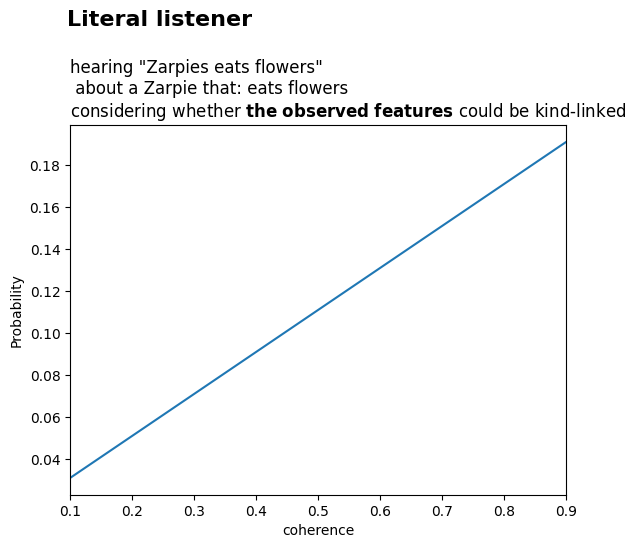

In [8]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Literal listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_generic_1_coherence.png", bbox_inches = "tight")
plt.show(g)

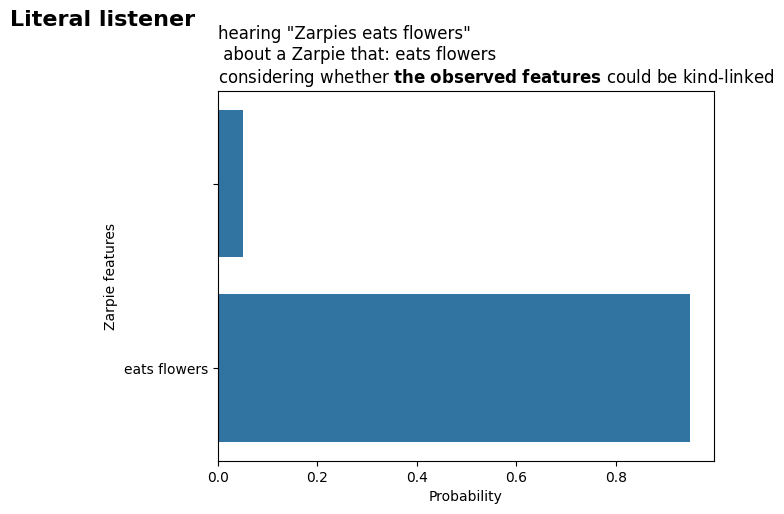

In [9]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Literal listener",
             x = -0.2, y = 1.05,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_generic_1_features.png", bbox_inches = "tight")
plt.show(g)

hearing "Zarpies eat flowers" about a Zarpie that eats flowers and sings lovely songs

In [10]:
# set up data
data = (
    (Utterance(subj='Zarpies', feature='eats flowers'), 
     Instance(kind='Zarpie', features=('eats flowers', 'scared of shadows'))),
)

# run literal listener
dist = literal_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')


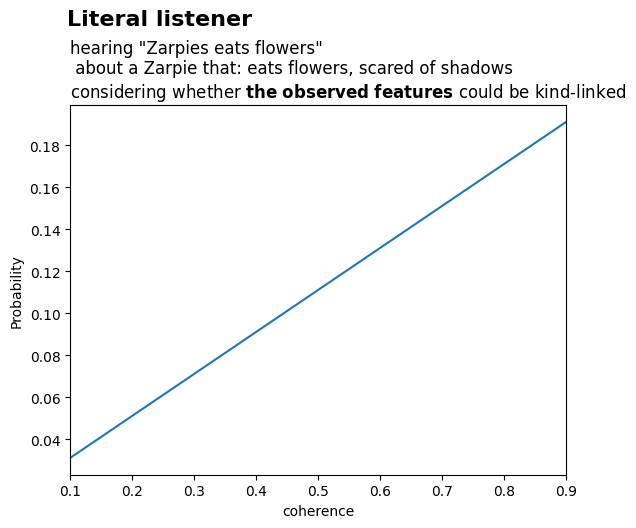

In [11]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Literal listener",
             x = 0.12, y = 1 + 0.08*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_generic_2_coherence.png", bbox_inches = "tight")
plt.show(g)

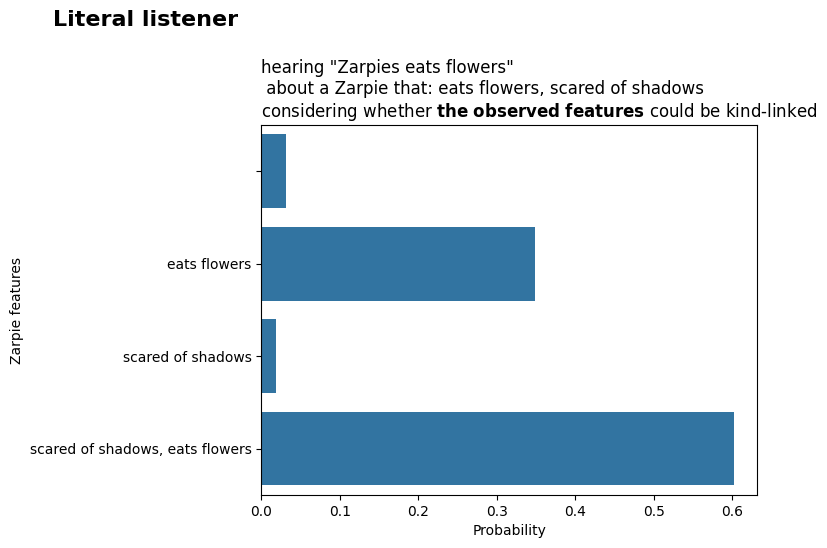

In [12]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Literal listener",
             x = -0.2, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_generic_2_features.png", bbox_inches = "tight")
plt.show(g)

#### Hearing a specific

* specifics are treated as irrelevant to coherence, and to kind status of the mentioned feature or unmentioned features

In [13]:
# set up data
data = (
    (Utterance(subj='This Zarpie', feature='eats flowers'), Instance(kind='Zarpie', features=('eats flowers',))) ,
    )

# run literal listener
dist = literal_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

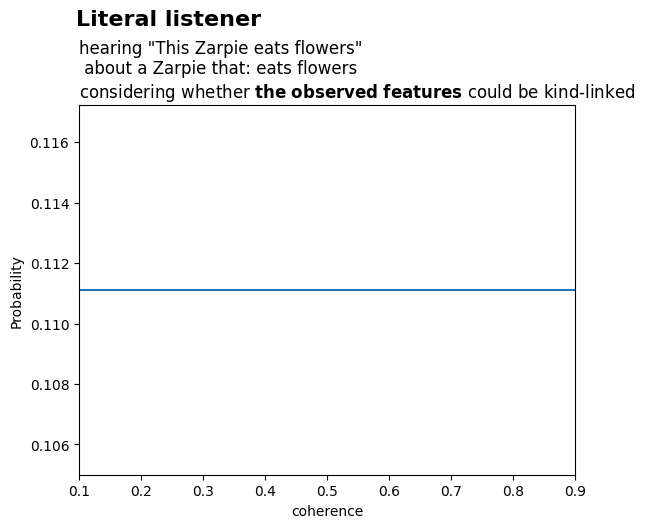

In [14]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Literal listener",
             x = 0.12, y = 1 + 0.08*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_specific_1_coherence.png", bbox_inches = "tight")
plt.show(g)

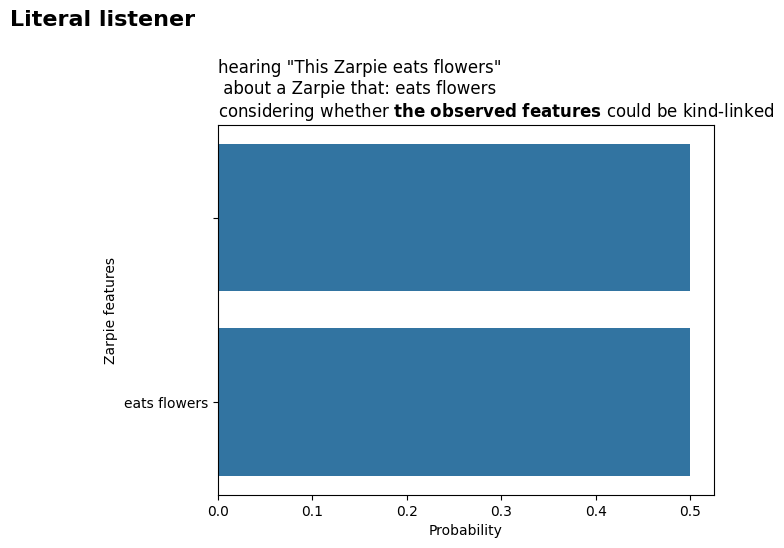

In [15]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Literal listener",
             x = -0.2, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_specific_1_features.png", bbox_inches = "tight")
plt.show(g)

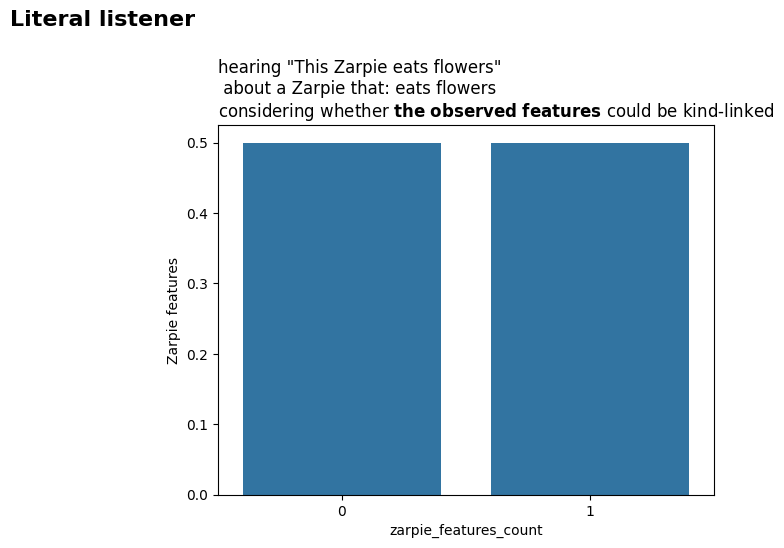

In [16]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features.groupby("zarpie_features_count").aggregate("sum").reset_index(),
                 x = "zarpie_features_count",
                 y = "Probability")
plt.ylabel("Zarpie features")
plt.suptitle("Literal listener",
             x = -0.2, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_specific_1_featurescount.png", bbox_inches = "tight")
plt.show(g)

#### Hearing multiple trials

In [17]:
# set up trials
data = (
    (Utterance("Zarpies", "eats flowers"), Instance("Zarpie", ("eats flowers",))),
    (Utterance("This Zarpie", "scared of shadows"), Instance("Zarpie", ("scared of shadows",)))
)

In [18]:
# run pragmatic listener
dist = literal_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

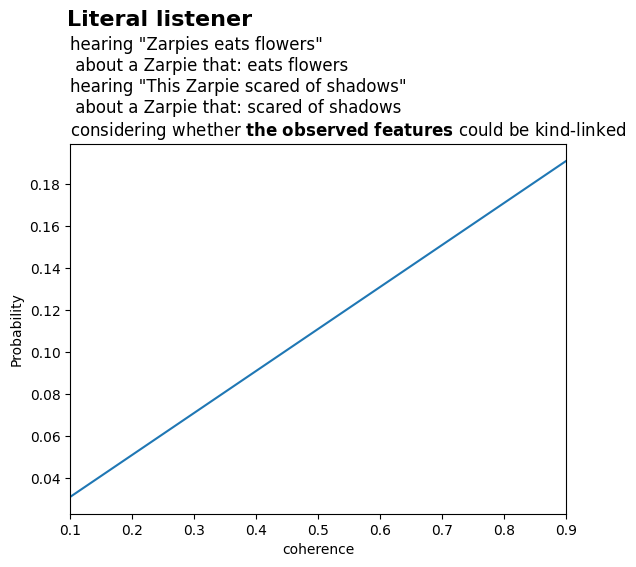

In [19]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Literal listener",
             x = 0.12, y = 1 + 0.08*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_multiple_1_coherence.png", bbox_inches = "tight")
plt.show(g)

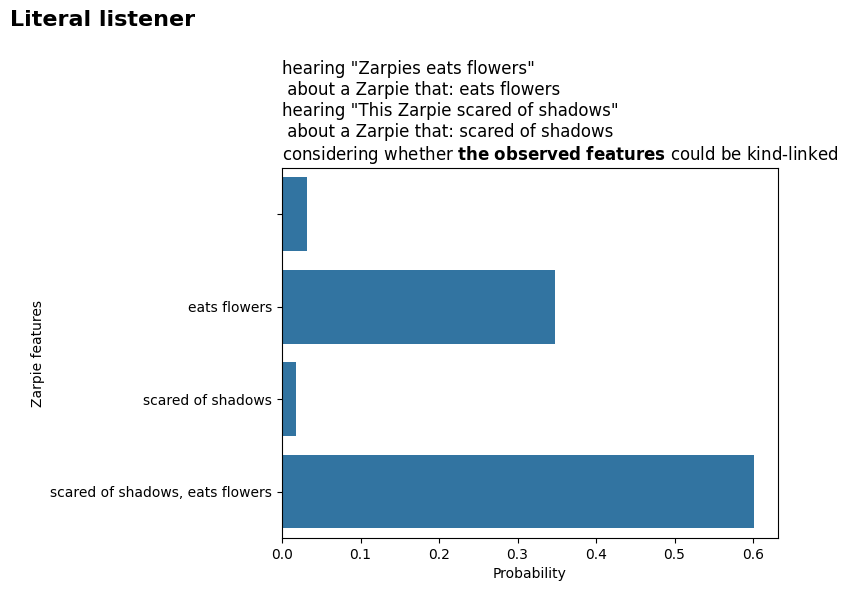

In [20]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Literal listener",
             x = -0.3, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/literal_listener_multiple_1_features.png", bbox_inches = "tight")
plt.show(g)

## Speaker

* **Jaccard similarity**: ranges between 0 and 1 for two sets $A$ and $B$ (footnote 1):

$$\text{Similarity}(A, B) = \frac{|A \cap B|}{|A \cup B|}$$

* **utility function**: speaker is trying to align what their listener infers about the observed features of the individual $\mathcal{F}_k$ with the true kind-linked status of those features $\mathcal{F}_k^*$ (eq. 4, the note below eq. 4):
    * First term - literal listener's posterior probability of kind-linked features, out of the individual's features
    * Second term - similarity between that set of features and the true kind-linked status of those features
    * Multiplying them for each Fk, and then summing over all Fks in the distribution, gives you the expected utility

$$\text{Utility}(u_i, x_i, \mathcal{F}_k^*) = \sum_{\mathcal{F}_k} \text{Lit}(\mathcal{F}_k|x_i, u_i) \cdot \text{Similarity}(\mathcal{F}_k^* \cup x_i, \mathcal{F}_k \cup x_i)$$

$$\text{Lit}(\mathcal{F}_k|x_i, u_i) = \int \text{Lit}(\mathcal{F}_k, \theta | x_i, u_i)d\theta$$


In [21]:
def jaccard_similarity(set_a, set_b):
    if len(set_a) == 0 and len(set_b) == 0:
        return 1 # if both lists are empty, return 1
    else:
        return len(set.intersection(set_a, set_b)) \
            / len(set.union(set_a, set_b))

In [22]:
@keep_deterministic
def utility_func(pair: tuple[Utterance, Instance],
                 kind_features: tuple[str, ...]):
    # run literal listener
    data = (pair, )
    dist = literal_listener(data)
    
    utt = pair[0]
    inst = pair[1]
    
    # only seen one trial
    observed_features_so_far = inst.features
    
    # compare similarity of inferred kind-linked features to true kind features
    def f(x):
        
        # NOTE: restricted to observed features from data
        return jaccard_similarity(set(kind_features) & set(observed_features_so_far), 
                                  set(x["zarpie_features"]) & set(observed_features_so_far))
        
        ## NOTE: across all kind-linked features known to the speaker
        # return jaccard_similarity(set(kind_features), 
        #                           set(x["zarpie_features"]))
    
    # calculate expected value over all sets of features, collapsing across coherence
    exp_utility = dist.expected_value(f)
    
    return exp_utility


* **speaker**: speaker is trying to maximize utility with some rationality/inverse temp $\beta$ (eq. 5):

$$\text{Speaker}(u_i|\mathcal{F}_k^*, x_i) \propto \text{exp}(\beta \cdot \text{Utility}(u_i, x_i, \mathcal{F}_k^*))$$

In [23]:
@infer
def speaker(kind_features: Kind.features, observed_instance: Instance, inv_temp = 2):
    utt = Utterance(subj = draw_from(["Zarpies", "This Zarpie"]),       # consider saying generic or specific..
                    feature = draw_from(observed_instance.features))    # ..about some feature of observed instance
    utility = utility_func((utt, observed_instance), 
                           kind_features)                               # consider what literal listener will infer (about zarpie features, coherence) from utterance
                                                                        # how close is literal listener's inferences to true zarpie features
    # weight = utility**inv_temp                                        # maximize utility, with inv_temp rationality
    weight = math.exp(inv_temp*utility)                                 # version to avoid issues with 0 utility
    condition(weight)
    
    return utt

### Model predictions

In [24]:
# set up kind-linked features
zarpies = Kind("Zarpies", ("eats flowers", "sings lovely songs", "jumps over puddles")) # Zarpies have these kind-linked features

# set up instance in data
example_zarpie = Instance("Zarpies", ("eats flowers", ))    # observe an instance of Zarpie that has these features

# run speaker model
dist = speaker(kind_features = zarpies.features, 
                       observed_instance = example_zarpie)

dist

feature,subj,Probability
eats flowers,Zarpies,0.711
eats flowers,This Zarpie,0.289


In [25]:
print(dist)

DiscreteInferenceResult(support=(Utterance(subj='Zarpies', feature='eats flowers'), Utterance(subj='This Zarpie', feature='eats flowers')), probabilities=(np.float64(0.7109495026250039), np.float64(0.2890504973749961)))


In [26]:
dist_to_df(dist)

,subj,feature,Probability
0,Zarpies,eats flowers,0.71095
1,This Zarpie,eats flowers,0.28905


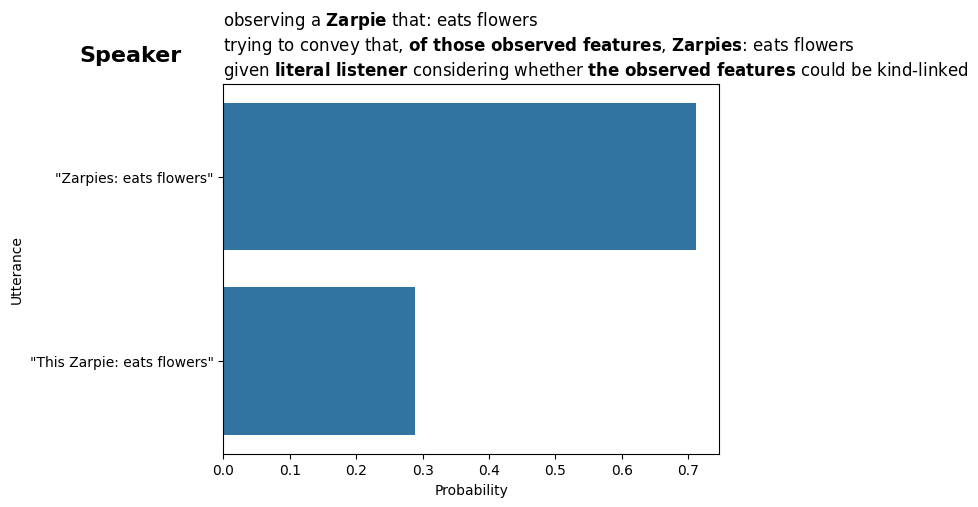

In [27]:
# convert to data frame
df_dist = dist_to_df(dist)
df_dist['Utterance'] = "\"" + df_dist['subj'] + ": " + df_dist['feature'] + "\""

# plot
g = sns.barplot(data = df_dist,
                 x = "Probability",
                 y = "Utterance")
plt.suptitle("Speaker",
             x = -0.1, y = 0.96,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title(r"observing a $\bf{Zarpie}$ that: " +
             ", ".join(example_zarpie.features) + "\n" +
             r"trying to convey that, $\bf{of}$ $\bf{those}$ $\bf{observed}$ $\bf{features}$, $\bf{Zarpies}$: " + 
             ", ".join(set(example_zarpie.features) & set(zarpies.features)) + "\n" +
             r"given $\bf{literal}$ $\bf{listener}$ considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
             x = 0, y = 1,
             horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/speaker_kindlinked.png", bbox_inches = "tight")
plt.show(g)

#### No generic exaggeration effect

* **Generic exaggeration effect** - speaker more likely to say a generic about a feature true of individual but not true of kind, over a specific, to get listener to believe the kind does share other features that it does in fact share

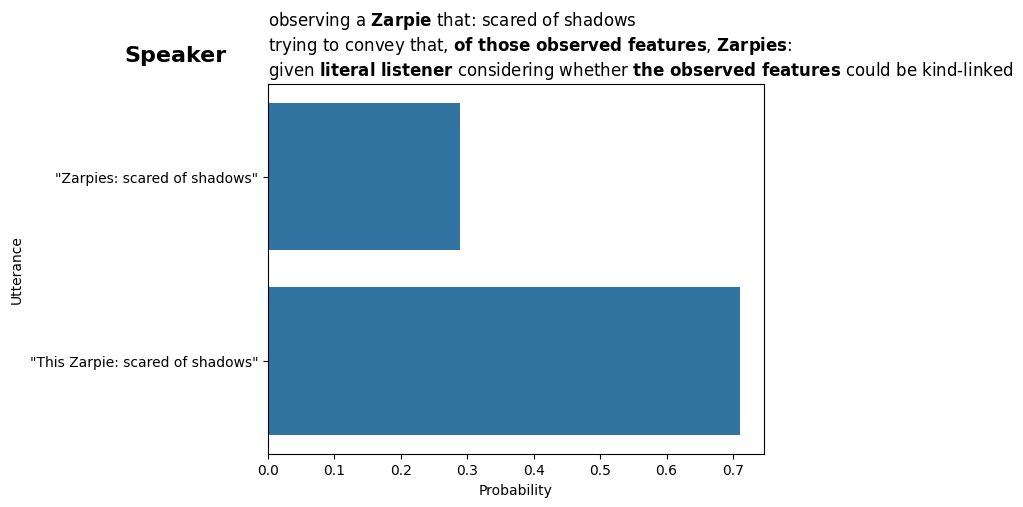

In [28]:
# set up data
zarpies = Kind("Zarpies", ("eats flowers", "sings lovely songs", "jumps over puddles")) # Zarpies have these kind-linked features
example_zarpie = Instance("Zarpies", ("scared of shadows", ))    # observe an instance of Zarpie that has these features

# run speaker model
dist = speaker(kind_features = zarpies.features, 
               observed_instance = example_zarpie)

# convert to data frame
df_dist = dist_to_df(dist)
df_dist['Utterance'] = "\"" + df_dist['subj'] + ": " + df_dist['feature'] + "\""

# plot
g = sns.barplot(data = df_dist,
                 x = "Probability",
                 y = "Utterance")
plt.suptitle("Speaker",
             x = -0.1, y = 0.96,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title(r"observing a $\bf{Zarpie}$ that: " +
             ", ".join(example_zarpie.features) + "\n" +
             r"trying to convey that, $\bf{of}$ $\bf{those}$ $\bf{observed}$ $\bf{features}$, $\bf{Zarpies}$: " + 
             ", ".join(set(example_zarpie.features) & set(zarpies.features)) + "\n" +
             r"given $\bf{literal}$ $\bf{listener}$ considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
             x = 0, y = 1,
             horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/speaker_1idiosyncratic.png", bbox_inches = "tight")
plt.show(g)

In [29]:
print(dist)

DiscreteInferenceResult(support=(Utterance(subj='Zarpies', feature='scared of shadows'), Utterance(subj='This Zarpie', feature='scared of shadows')), probabilities=(np.float64(0.28905049737499605), np.float64(0.7109495026250039)))


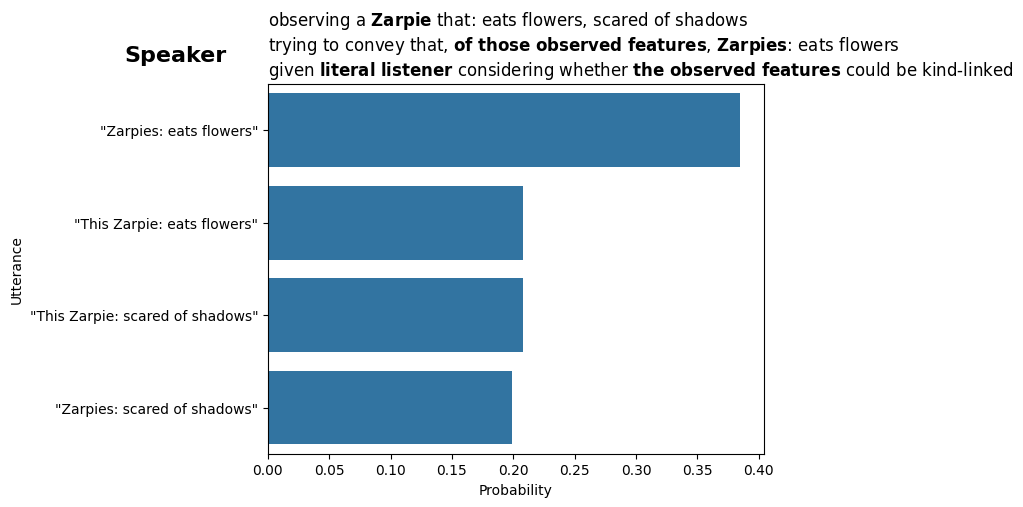

In [30]:
# set up data
zarpies = Kind("Zarpies", ("eats flowers", "sings lovely songs", "jumps over puddles")) # Zarpies have these kind-linked features
example_zarpie = Instance("Zarpies", ("eats flowers", "scared of shadows"))             # observe an instance of Zarpie that has these features

# run speaker model
dist = speaker(kind_features = zarpies.features, 
               observed_instance = example_zarpie)

# convert to data frame
df_dist = dist_to_df(dist)
df_dist['Utterance'] = "\"" + df_dist['subj'] + ": " + df_dist['feature'] + "\""

# plot
g = sns.barplot(data = df_dist,
                 x = "Probability",
                 y = "Utterance")
plt.suptitle("Speaker",
             x = -0.1, y = 0.96,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title(r"observing a $\bf{Zarpie}$ that: " +
             ", ".join(example_zarpie.features) + "\n" +
             r"trying to convey that, $\bf{of}$ $\bf{those}$ $\bf{observed}$ $\bf{features}$, $\bf{Zarpies}$: " + 
             ", ".join(set(example_zarpie.features) & set(zarpies.features)) + "\n" +
             r"given $\bf{literal}$ $\bf{listener}$ considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
             x = 0, y = 1,
             horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/speaker_1kindlinked_1idiosyncratic.png", bbox_inches = "tight")
plt.show(g)

## Pragmatic listener

Pragmatic listener is reasoning, not about literal truth-value of utterances, but about likelihood that a speaker reasoning about a literal listener will produce the utterance. 

Replace the literal semantics likelihood in Equation 2 with the speaker likelihood (Equation 5) to make eq. 6:

$$\text{Prag}(\mathcal{F}_k, \theta | x, u) \propto P(\theta)P(\mathcal{F}_k|\theta)\prod_{i}\text{Sp}(u_i|\mathcal{F}_k, x_i)$$

In [31]:
# this needs to be kept deterministic since 
# marginalize is being transformed, which we do not want
@keep_deterministic
def calc_utt_likelihood(features, inst, utt):
    # run speaker model
    dist = speaker(features, inst)
    # what is likelihood of saying the utterance heard (over all coherences)
    utt_likelihood = dist.marginalize(lambda x: utt == x).prob(True)
    return utt_likelihood

In [32]:
@infer
def pragmatic_listener(data: tuple[tuple[Utterance, Instance]]):
    # sample a coherence
    coherence = draw_from([.1, .2, .3, .4, .5, .6, .7, .8, .9])
    
    # extract all features from observed data
    all_observed_features = ()
    for pair in data:
        inst = pair[1]
        all_observed_features = all_observed_features + inst.features
    all_features = tuple(set(all_observed_features))
    
    # draw a subset of all features, based on coherence
    # coherence = likelihood of sampling a given feature, higher coherence ~ more kind-linked features
    some_features = tuple([f for f in all_features if flip(coherence)])
    
    # define zarpie concept to have those features
    zarpies = Kind("Zarpies", some_features)
    
    # for each utterance-instance pair in data:
    for pair in data:
        # get utterance and instance
        utt = pair[0]
        inst = pair[1]
        
        # run speaker on hypothesized zarpie features, instance
        # likelihood = speaker's probability of saying the utterance
        # cf. literal listener, which uses literal meaning as likelihood
        utt_likelihood = calc_utt_likelihood(zarpies.features, inst, utt)
        
        # condition on speaker likelihood
        condition(utt_likelihood) 
        
    return hashabledict(zarpie_features = zarpies.features, coherence = coherence)
    # return "jumps over puddles" in zarpies.features

### Model predictions

#### Hearing a generic

In [33]:
# set up data
data = (
    (Utterance(subj='Zarpies', feature='eats flowers'), Instance(kind='Zarpie', features=('eats flowers', ))),
)

In [34]:
# run pragmatic_listener
dist = pragmatic_listener(data)

# convert inferred set of zarpie features & coherence to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

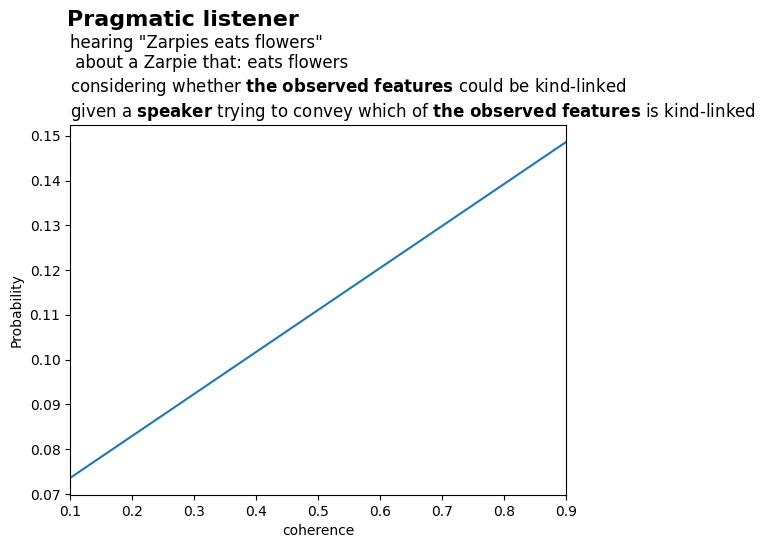

In [35]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_generic_1_coherence.png", bbox_inches = "tight")
plt.show(g)

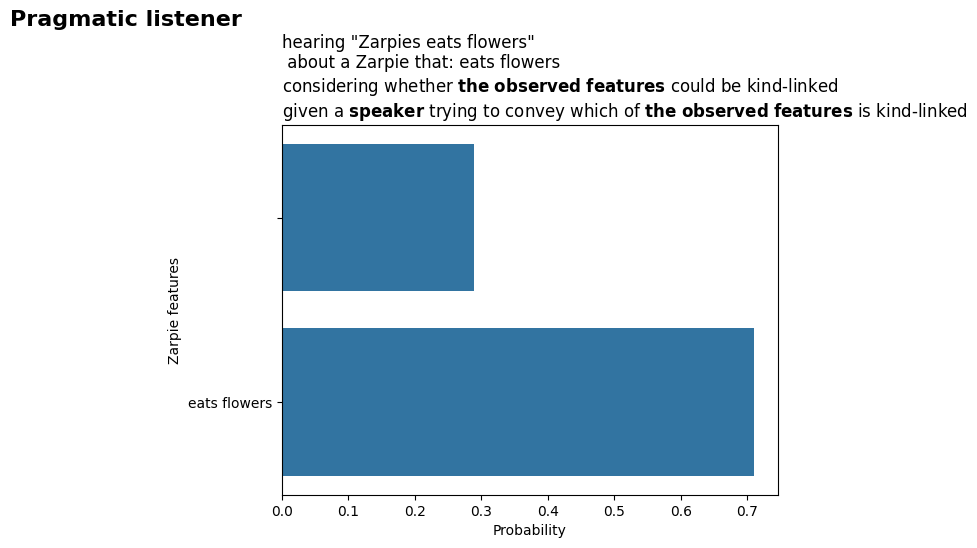

In [36]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_generic_1_features.png", bbox_inches = "tight")
plt.show(g)

In [37]:
# set up data
data = (
    (Utterance(subj='Zarpies', feature='eats flowers'), 
     Instance(kind='Zarpie', features=('eats flowers', 'scared of shadows'))),
)

In [38]:
# run pragmatic_listener
dist = pragmatic_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

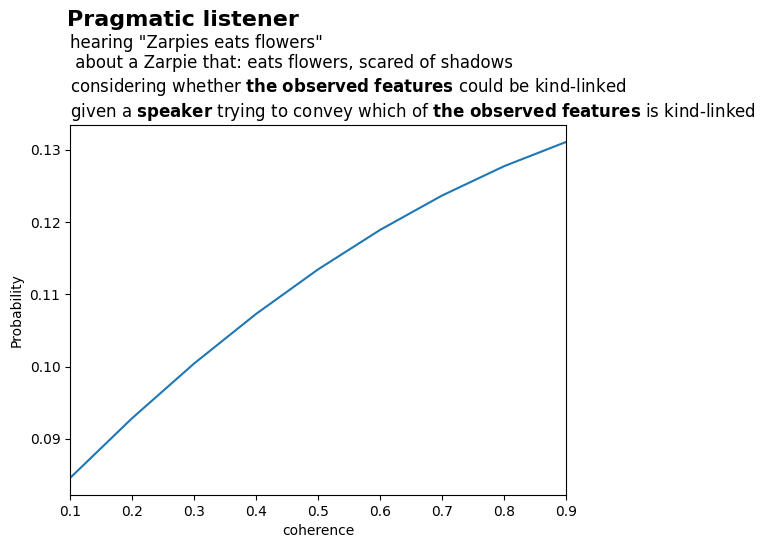

In [39]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_generic_2_coherence.png", bbox_inches = "tight")
plt.show(g)

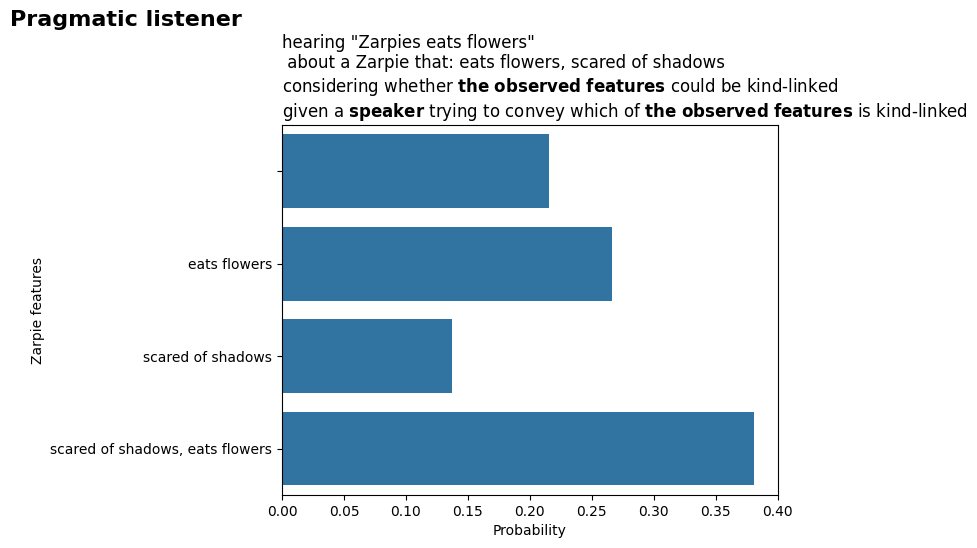

In [40]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_generic_2_features.png", bbox_inches = "tight")
plt.show(g)

#### Hearing a specific

In [41]:
# set up trial
data = (
    (Utterance(subj='This Zarpie', feature='eats flowers'), 
     Instance(kind='Zarpie', features=('eats flowers', ))) ,
)

# run pragmatic listener
dist = pragmatic_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

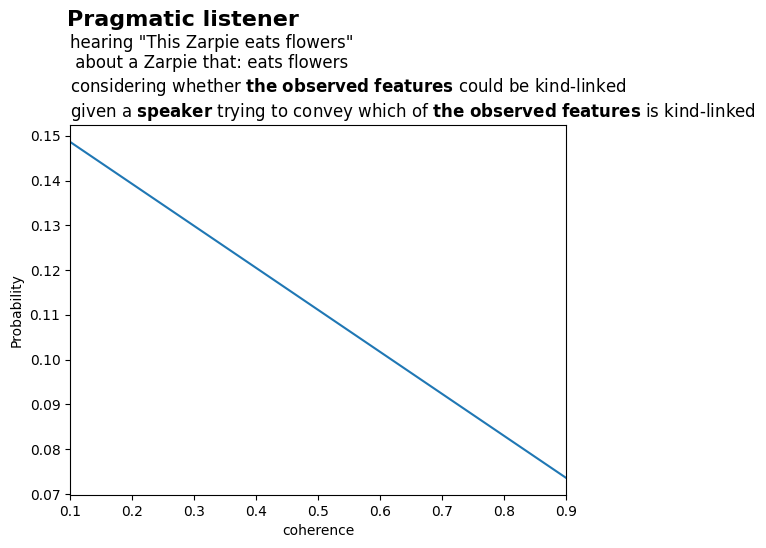

In [42]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_specific_1_coherence.png", bbox_inches = "tight")
plt.show(g)

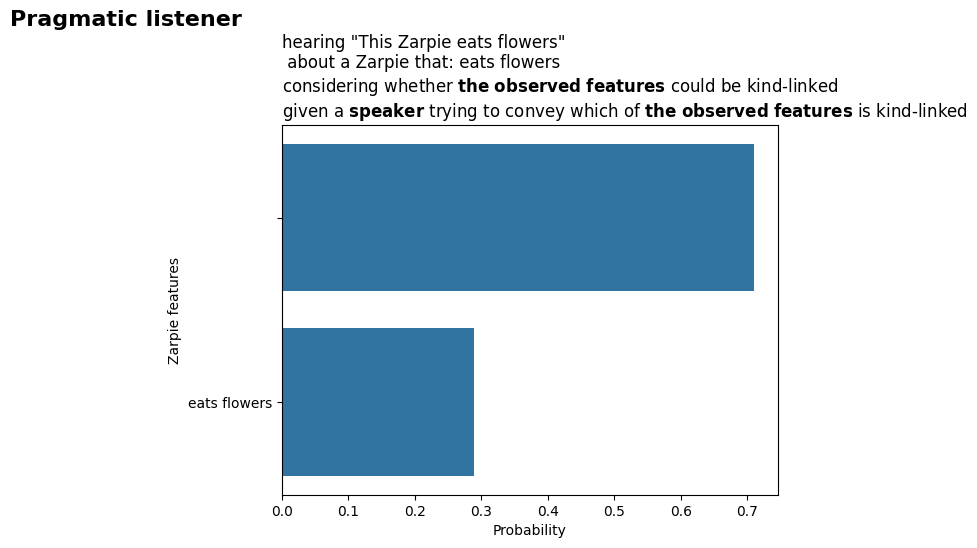

In [43]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_specific_1_features.png", bbox_inches = "tight")
plt.show(g)

In [44]:
# set up trial
data = (
    (Utterance(subj='This Zarpie', feature='eats flowers'), 
     Instance(kind='Zarpie', features=('eats flowers', 'scared of shadows'))) ,
)

# run pragmatic listener
dist = pragmatic_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

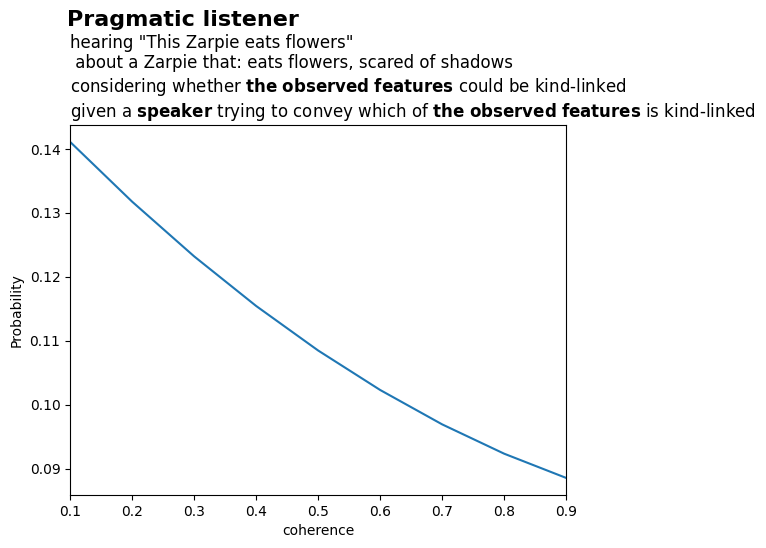

In [45]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1 + 0.12*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_specific_2_coherence.png", bbox_inches = "tight")
plt.show(g)

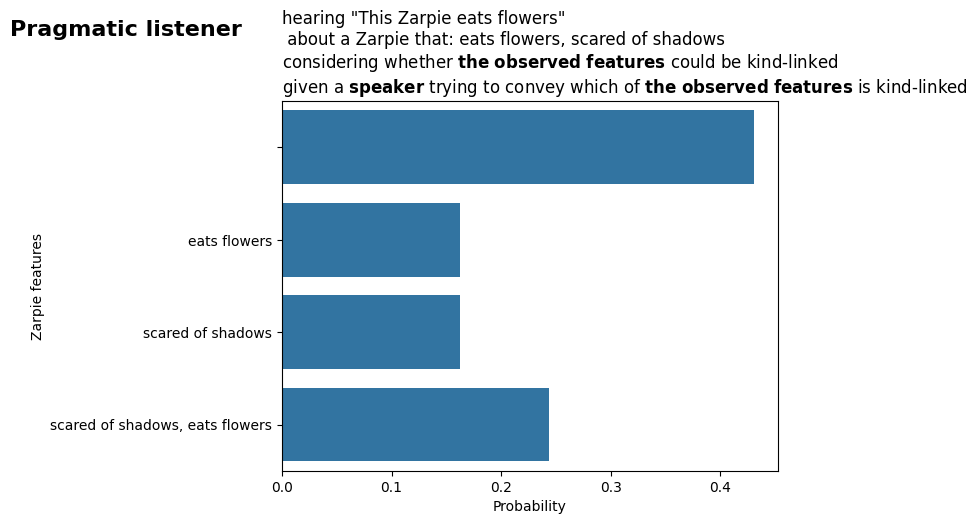

In [46]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.05,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_specific_2_features.png", bbox_inches = "tight")
plt.show(g)

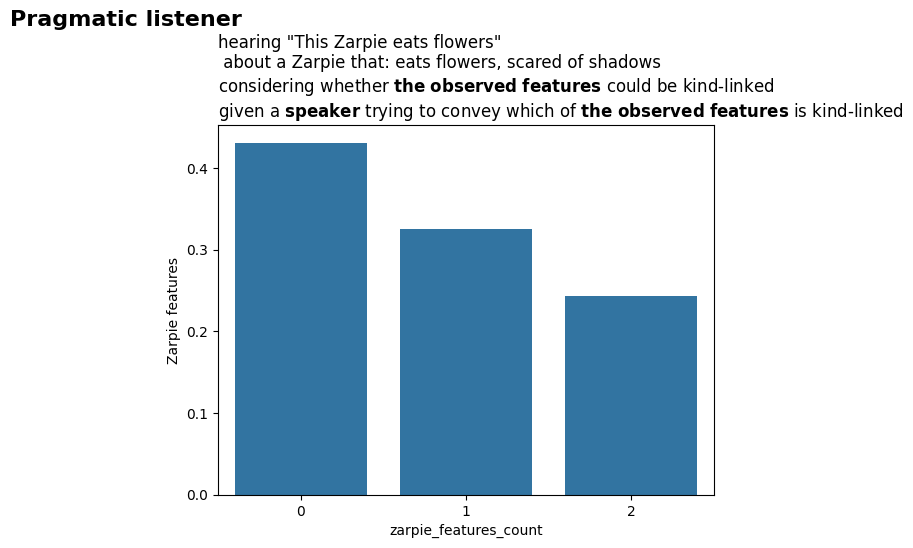

In [47]:
# plot number of inferred features
g = sns.barplot(data = df_zarpie_features.groupby("zarpie_features_count").aggregate("sum").reset_index(),
                 x = "zarpie_features_count",
                 y = "Probability")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.2, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_specific_2_featurescount.png", bbox_inches = "tight")
plt.show(g)

#### Hearing multiple trials

In [48]:
# set up trials
data = (
    (Utterance("Zarpies", "eats flowers"), Instance("Zarpie", ("eats flowers", ))),
    (Utterance("This Zarpie", "scared of shadows"), Instance("Zarpie", ("scared of shadows", )))
)

In [49]:
# run pragmatic listener
dist = pragmatic_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

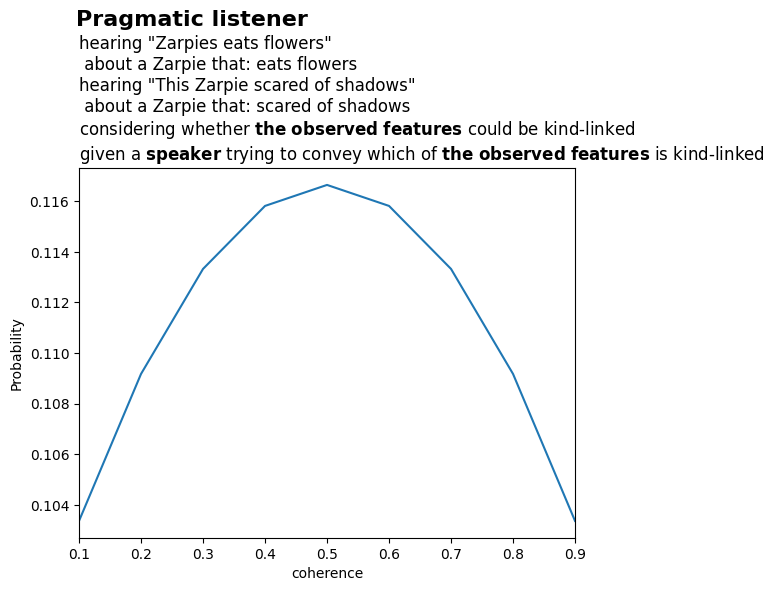

In [50]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_multiple_1_coherence.png", bbox_inches = "tight")
plt.show(g)

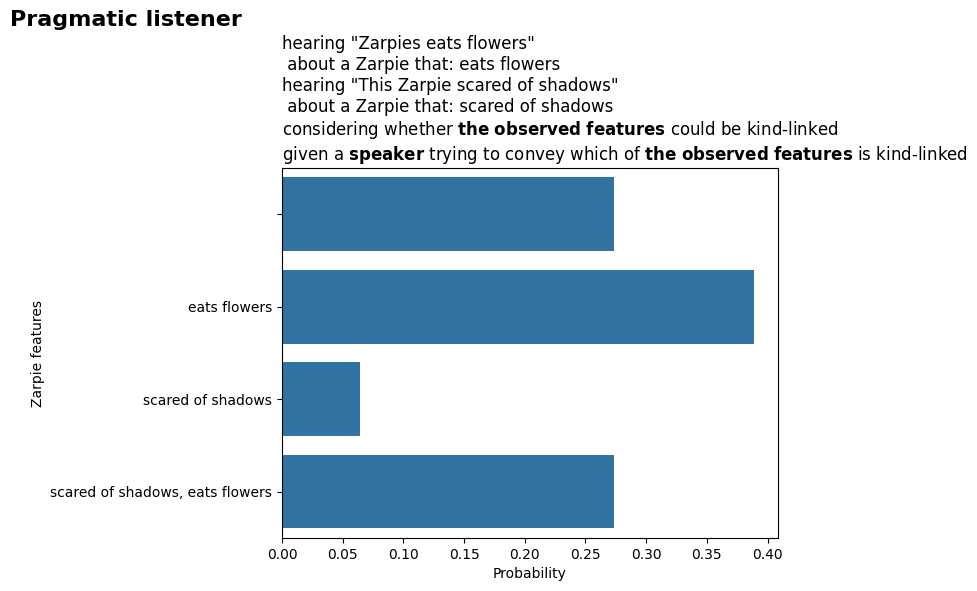

In [51]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_multiple_1_features.png", bbox_inches = "tight")
plt.show(g)

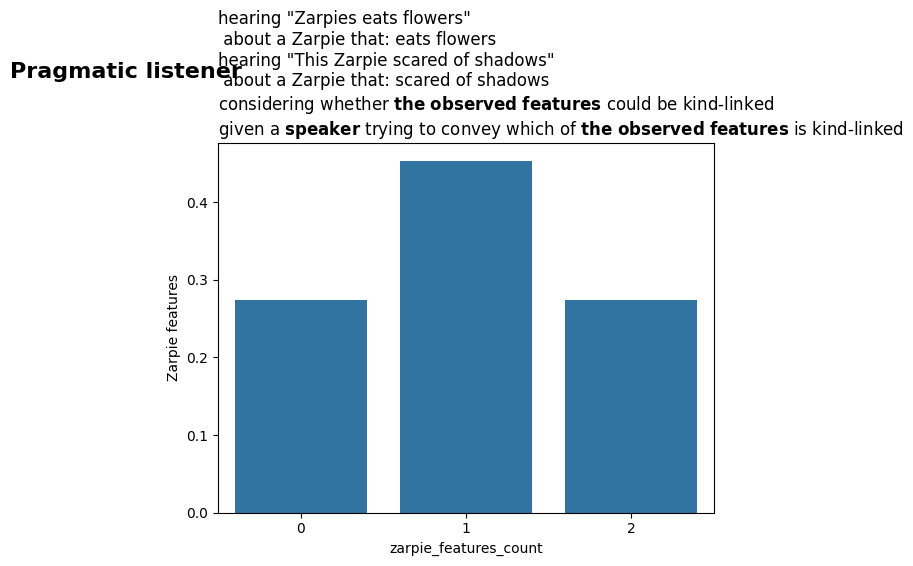

In [52]:
# plot number of inferred features
g = sns.barplot(data = df_zarpie_features.groupby("zarpie_features_count").aggregate("sum").reset_index(),
                 x = "zarpie_features_count",
                 y = "Probability")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.2, y = 1.05,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_multiple_1_featurescount.png", bbox_inches = "tight")
plt.show(g)

In [53]:
# set up trials
data = (
    (Utterance("Zarpies", "eats flowers"), Instance("Zarpie", ("eats flowers", ))),
    (Utterance("This Zarpie", "scared of shadows"), Instance("Zarpie", ("scared of shadows", ))),
    (Utterance("This Zarpie", "jumps over puddles"), Instance("Zarpie", ("jumps over puddles", "sings lovely songs")))
)

In [54]:
# run pragmatic listener
dist = pragmatic_listener(data)

# convert to df
df = dist_to_df(dist)

# separate inferred zarpie features vs inferred coherence
df_coherence = df.groupby('coherence').agg({'Probability': 'sum'})
df_zarpie_features = df.groupby('zarpie_features').agg({'Probability': 'sum'}).reset_index()

# convert tuples of features to string, sort by number of features
df_zarpie_features['zarpie_features_string'] = [', '.join(el) for el in df_zarpie_features['zarpie_features']] 
df_zarpie_features['zarpie_features_count'] = df_zarpie_features['zarpie_features'].apply(len)
df_zarpie_features = df_zarpie_features.sort_values(by='zarpie_features_count')

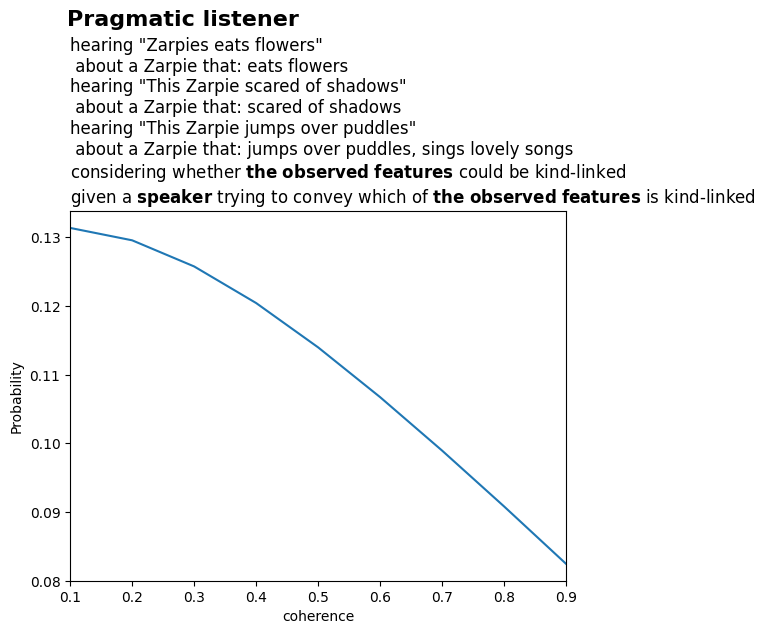

In [55]:
# plot coherence
g = sns.lineplot(data = df_coherence,
                 x = "coherence",
                 y = "Probability")
plt.xlim(.1, .9)
plt.suptitle("Pragmatic listener",
             x = 0.12, y = 1.03 + 0.09*len(data),
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_multiple_2_coherence.png", bbox_inches = "tight")
plt.show(g)

* hearing enough specifics can actually outweigh a generic via coherence

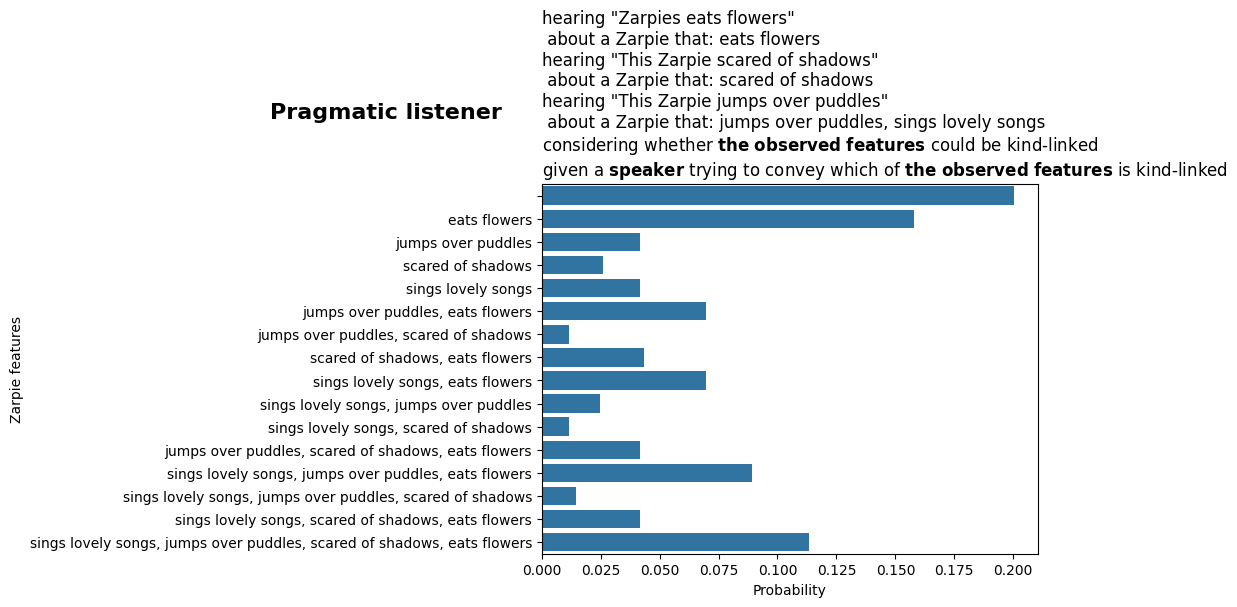

In [56]:
# plot inferred features
g = sns.barplot(data = df_zarpie_features,
                 x = "Probability",
                 y = "zarpie_features_string")
plt.ylabel("Zarpie features")
plt.suptitle("Pragmatic listener",
             x = -0.3, y = 1.05,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title("".join(["hearing \"" + " ".join(pair[0]) + "\"" +
                   "\n about a " + pair[1].kind + \
          " that: " + ", ".join(pair[1].features) + "\n" for pair in data]) +
          
          r"considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked" + "\n" +
          r"given a $\bf{speaker}$ trying to convey which of $\bf{the}$ $\bf{observed}$ $\bf{features}$ is kind-linked",
          
          x = 0, y = 1,
          horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/pragmatic_listener_multiple_2_features.png", bbox_inches = "tight")
plt.show(g)

## Speaker 2

In [57]:
@keep_deterministic
def utility_func2(pair: tuple[Utterance, Instance],
                  kind_features: tuple[str, ...]):
    # run *pragmatic* listener
    data = (pair, )
    dist = pragmatic_listener(data)
    
    utt = pair[0]
    inst = pair[1]
    
    # only seen one trial
    observed_features_so_far = inst.features
    
    # compare similarity of inferred kind-linked features to true kind features
    def f(x):
        
        # NOTE: restricted to observed features from data
        return jaccard_similarity(set(kind_features) & set(observed_features_so_far), 
                                  set(x["zarpie_features"]) & set(observed_features_so_far))
        
        ## NOTE: across all kind-linked features known to the speaker
        # return jaccard_similarity(set(kind_features), 
        #                           set(x["zarpie_features"]))
    
    # calculate expected value over all sets of features, collapsing across coherence
    exp_utility = dist.expected_value(f)
    
    return exp_utility

In [58]:
@infer
def speaker2(kind_features: Kind.features, observed_instance: Instance, 
             inv_temp = 2):
    utt = Utterance(subj = draw_from(["Zarpies", "This Zarpie"]),       # consider saying generic or specific..
                    feature = draw_from(observed_instance.features))    # ..about some feature of observed instance
    utility = utility_func2((utt, observed_instance), kind_features)   # consider what *pragmatic* listener will infer (about zarpie features, coherence) from utterance
                                                                        # how close is *pragmatic* listener's inferences to true zarpie features
    # weight = utility**inv_temp                                        # maximize utility, with inv_temp rationality
    weight = math.exp(inv_temp*utility)                                 # version to avoid issues with 0 utility
    condition(weight)
    return utt

### Model predictions

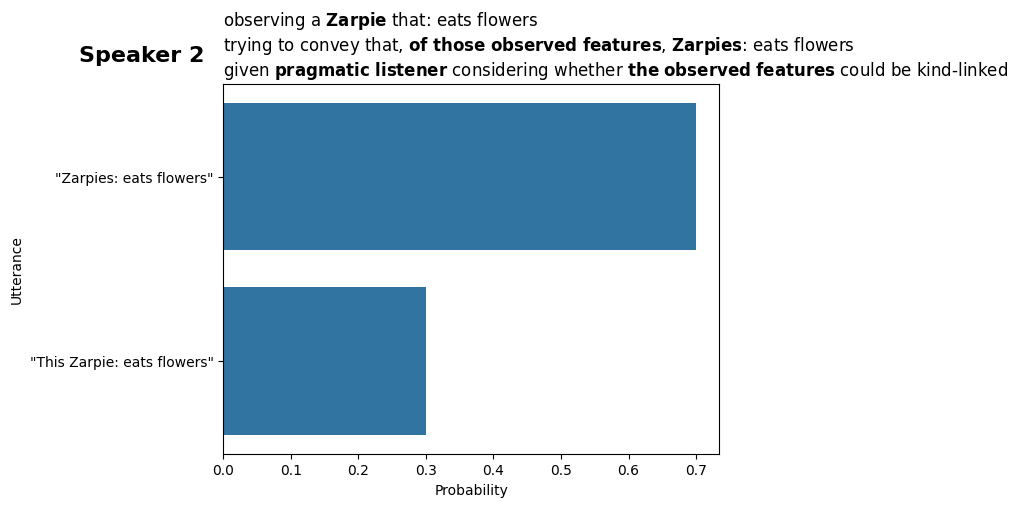

In [59]:
# set up data
zarpies = Kind("Zarpies", ("eats flowers", "sings lovely songs", "jumps over puddles")) # Zarpies have these kind-linked features
example_zarpie = Instance("Zarpies", ("eats flowers", ))    # observe an instance of Zarpie that has these features

# run speaker model
speaker_dist = speaker2(kind_features = zarpies.features, 
                       observed_instance = example_zarpie)

# convert to data frame
df_speaker_dist = dist_to_df(speaker_dist)
df_speaker_dist['Utterance'] = "\"" + df_speaker_dist['subj'] + ": " + df_speaker_dist['feature'] + "\""

# plot
g = sns.barplot(data = df_speaker_dist,
                 x = "Probability",
                 y = "Utterance")
plt.suptitle("Speaker 2",
             x = -0.1, y = 0.96,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title(r"observing a $\bf{Zarpie}$ that: " +
             ", ".join(example_zarpie.features) + "\n" +
             r"trying to convey that, $\bf{of}$ $\bf{those}$ $\bf{observed}$ $\bf{features}$, $\bf{Zarpies}$: " + 
             ", ".join(set(example_zarpie.features) & set(zarpies.features)) + "\n" +
             r"given $\bf{pragmatic}$ $\bf{listener}$ considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
             x = 0, y = 1,
             horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/speaker2_1kindlinked.png", bbox_inches = "tight")
plt.show(g)

#### Generic exaggeration effect

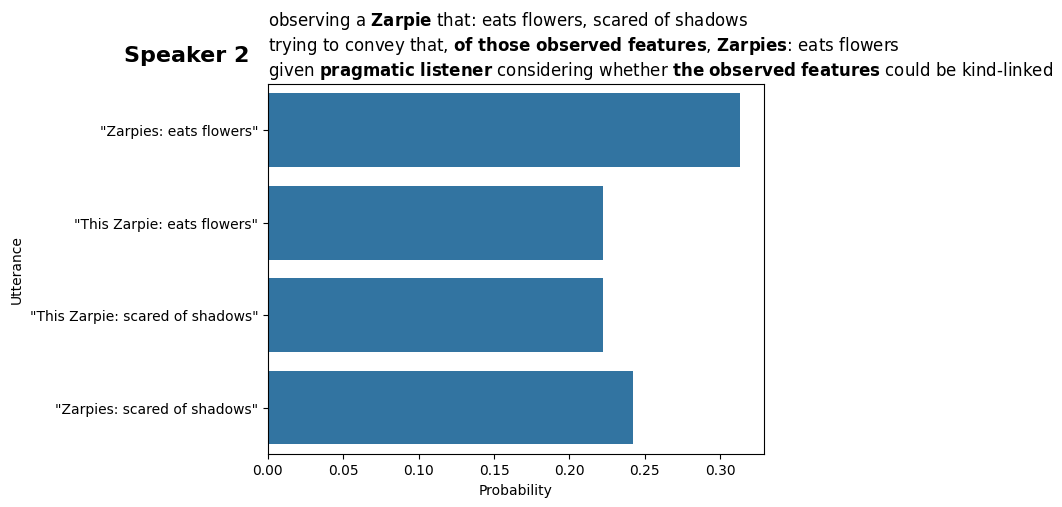

In [60]:
# set up data
zarpies = Kind("Zarpies", ("eats flowers", "sings lovely songs", "jumps over puddles")) # Zarpies have these kind-linked features
example_zarpie = Instance("Zarpies", ("eats flowers", "scared of shadows"))             # observe an instance of Zarpie that has these features

# run speaker model
speaker_dist = speaker2(kind_features = zarpies.features, 
                       observed_instance = example_zarpie)

# convert to data frame
df_speaker_dist = dist_to_df(speaker_dist)
df_speaker_dist['Utterance'] = "\"" + df_speaker_dist['subj'] + ": " + df_speaker_dist['feature'] + "\""

# plot
g = sns.barplot(data = df_speaker_dist,
                 x = "Probability",
                 y = "Utterance")
plt.suptitle("Speaker 2",
             x = -0.1, y = 0.96,
             horizontalalignment = "left",
             fontsize = 16,
             fontweight = "bold")
plt.title(r"observing a $\bf{Zarpie}$ that: " +
             ", ".join(example_zarpie.features) + "\n" +
             r"trying to convey that, $\bf{of}$ $\bf{those}$ $\bf{observed}$ $\bf{features}$, $\bf{Zarpies}$: " + 
             ", ".join(set(example_zarpie.features) & set(zarpies.features)) + "\n" +
             r"given $\bf{pragmatic}$ $\bf{listener}$ considering whether $\bf{the}$ $\bf{observed}$ $\bf{features}$ could be kind-linked",
             x = 0, y = 1,
             horizontalalignment = "left")

plt.savefig("figs_listenerspeakerexamplefeaturesonly/speaker2_1kindlinked_1notkindlinked.png", bbox_inches = "tight")
plt.show(g)